# Genetic programming: symbolic regresion

In [65]:
%load_ext autoreload
%autoreload 2
import gp
import plotting as pl
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from random import seed
from math import sin, cos, pi, exp, sqrt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
# set of problems
problems = ({'func' : lambda x,y: x**2 + sin(y), 'interval' : np.array(list(product(np.arange(-3,3,0.25), np.arange(-3,3,0.25)))), 'name' : 'sin(x^2) * y'},)
def generate_dataset(inputs, func):
    outputs = np.zeros_like(inputs[:, 0])
    for i, t in enumerate(inputs):
        outputs[i] = func(*t)
    return np.column_stack([inputs, np.vstack(outputs)])

#inputs = np.array(list(itertools.product(np.arange(-2, 2, 1.0), np.arange(-1, 1, 1.0))))
#print(generate_dataset(problems[0]['interval'], lambda x: x + 1))

In [100]:
# gp parameters
def add(x, y): return x + y
def sub(x, y): return x - y
def mul(x, y): return x * y
def safe_div(x, y): return x / y if y != 0 else x

BINARY_FUNCTIONS = (add, sub, mul, safe_div)
UNARY_FUNCTIONS = (abs, sin)
FUNC_NAMES = {add : '+', sub : '-', mul : '*', safe_div : '/', sin : 'sin', abs : 'abs'}
INPUTS = ['x', 'y']
TERMINALS = [-2, -1, 0, 1, 2, pi, exp(1)] + INPUTS


gp.Parameters.gp_rules = {
    'binary_functions' : BINARY_FUNCTIONS,
    'unary_functions' :  UNARY_FUNCTIONS,
    'func_names' :       FUNC_NAMES,
    'terminals' :        TERMINALS,
    'inputs' :           INPUTS,
    'pop_size' :         120, # population size
    'min_depth' :        2, # minimal initial random tree depth
    'max_depth' :        4, # maximal initial random tree depth
    'generations' :      100, # maximal number of generations to run evolution
    'tournament_size' :  3, # size of tournament for tournament selection
    'xo_rate' :          0.9, # crossover rate
    'prob_mutation' :    0.2, # per-node mutation probability
    'epsilon' :          0.1, # epsilon used to compute hit rate
}

(576, 3)


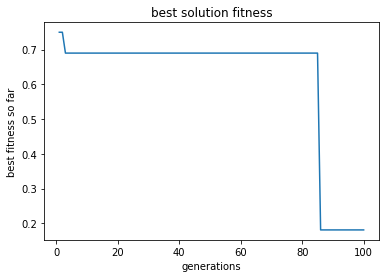

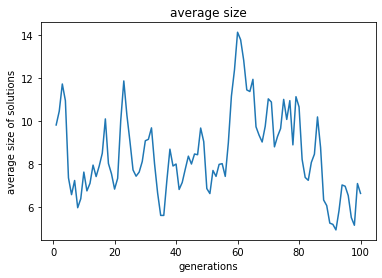

evolution ended after 101 generations, best solution with fitness 0.1811516900532068:
f_sol(x) = (sin(sin(y)) + (x * x))


In [101]:
# run gp on problems with parameters specified above
seed() # set seed here to reproduce same conditions
x = gp.GeneticProgram()
 
for problem in problems:
    d = generate_dataset(problem['interval'], problem['func'])
    res = x.run_evolution(d, verbose=False)
    # plot the results
    pl.simple_line_plot(list(range(1, res['generations'])), res['best_of_run_fitnesses'], 'generations', 'best fitness so far', 'best solution fitness')
    pl.simple_line_plot(list(range(1, res['generations'])), res['avg_sizes'], 'generations', 'average size of solutions', 'average size')
    #pl.plot_solution_and_target(res['best'], problem['name'], d)
    print(f'evolution ended after {res["generations"]} generations, best solution with fitness {res["best_f"]}:')
    print(f'f_sol(x) = {res["best"].to_str_simplified()}')